In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
import shap
import lime
from lime.lime_text import LimeTextExplainer
import re
import string
import spacy


In [ ]:
!pip install textattack

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 50.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 48.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.7/445.7 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install fasttext
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313472 sha256=1427546ba8fae4269d08b311424885ba3ea70fbe3e61720c8e62b8bb8a5075a3
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=eca907fd3e876fd2242d13f195d3c617b3ec69694148a5d39c34ac76086a61d8
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf44

In [ ]:
df = pd.read_csv('/content/output_final_numeric.csv')
df.head()

,label,Lemmatized_Text,label_des,Numeric_Vector
0,__label__normal,i dont think im getting my baby them white 9 h...,__label__normal i dont think im getting my bab...,[-0.0165415 0.01101303 0.0132383 -0.004891...
1,__label__normal,we can not continue calling ourselves feminist...,__label__normal we can not continue calling ou...,[-0.01084381 0.00615925 0.00959589 -0.003718...
2,__label__normal,nawt yall nigger ignoring me,__label__normal nawt yall nigger ignoring me,[ 6.15036525e-02 8.03055465e-02 -4.33806591e-...
3,__label__hate,< user > i am bit confused coz chinese ppl can...,__label__hate < user > i am bit confused coz c...,[ 6.09122508e-04 1.02284551e-02 2.91937540e-...
4,__label__hate,this bitch in whataburger eating a burger with...,__label__hate this bitch in whataburger eating...,[ 1.3369057e-02 -2.4465172e-02 -1.5899751e-02 ...


In [ ]:
df = df.drop(columns=['Numeric_Vector'])
df = df.drop(columns=['label_des'])

In [ ]:
df.head()

,label,Lemmatized_Text
0,__label__normal,i dont think im getting my baby them white 9 h...
1,__label__normal,we can not continue calling ourselves feminist...
2,__label__normal,nawt yall nigger ignoring me
3,__label__hate,< user > i am bit confused coz chinese ppl can...
4,__label__hate,this bitch in whataburger eating a burger with...


#Preprocessed Text

In [ ]:
def remove_urls(text):
  new_text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
  return new_text

# make all text lowercase
def text_lowercase(text):
  return text.lower()

# remove numbers
def remove_numbers(text):
  result = re.sub(r'\d+', '', text)
  return result

# remove punctuation
def remove_punctuation(text):
  translator = str.maketrans('', '', string.punctuation)
  return text.translate(translator)

In [ ]:
# function for all pre-processing steps
def preprocessing(text):
  text = text_lowercase(text)
  text = remove_urls(text)
  text = remove_numbers(text)
  text = remove_punctuation(text)
  return text

In [ ]:
df['Cleaned_Text'] = df['Lemmatized_Text'].apply(preprocessing)

In [ ]:
df.head()

,label,Lemmatized_Text,Cleaned_Text
0,__label__normal,i dont think im getting my baby them white 9 h...,i dont think im getting my baby them white he...
1,__label__normal,we can not continue calling ourselves feminist...,we can not continue calling ourselves feminist...
2,__label__normal,nawt yall nigger ignoring me,nawt yall nigger ignoring me
3,__label__hate,< user > i am bit confused coz chinese ppl can...,user i am bit confused coz chinese ppl can not...
4,__label__hate,this bitch in whataburger eating a burger with...,this bitch in whataburger eating a burger with...


In [ ]:
# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Function to remove stopwords
def remove_stopwords_spacy(text):
    doc = nlp(text)
    filtered_words = [token.text for token in doc if not token.is_stop]
    return " ".join(filtered_words)

In [ ]:
df1 = pd.read_csv("/content/regex_tutorial_exercise_answer.csv")

In [ ]:
df1.head()

,important_words
0,[]
1,[]
2,[]
3,"['ching', 'chong']"
4,"['bitch', 'i', 'hate', 'white', 'bitches']"


In [ ]:
df['rationales'] = df1['important_words']


In [ ]:
df.head()

,label,Lemmatized_Text,Cleaned_Text,rationales
0,__label__normal,i dont think im getting my baby them white 9 h...,i dont think im getting my baby them white he...,[]
1,__label__normal,we can not continue calling ourselves feminist...,we can not continue calling ourselves feminist...,[]
2,__label__normal,nawt yall nigger ignoring me,nawt yall nigger ignoring me,[]
3,__label__hate,< user > i am bit confused coz chinese ppl can...,user i am bit confused coz chinese ppl can not...,"['ching', 'chong']"
4,__label__hate,this bitch in whataburger eating a burger with...,this bitch in whataburger eating a burger with...,"['bitch', 'i', 'hate', 'white', 'bitches']"


In [ ]:
# Apply the function to the DataFrame column
df['Cleaned_Text'] = df['Cleaned_Text'].apply(remove_stopwords_spacy)

In [ ]:
# 🔹 Generate Character-Level Adversarial Text
def character_level_attack(text):
    replacements = {
        'a': '@', 'o': '0', 'e': '3', 's': '$', 'i': '1', 'u': 'v', 'l': '1', 'c':'^', 't':'7', 'g':'9'
    }
    return ''.join(replacements.get(c, c) for c in text)

In [ ]:
# 🔹 Generate Word-Level Adversarial Text (Synonym Replacement)
from textattack.augmentation import WordNetAugmenter
augmenter = WordNetAugmenter()
def word_level_attack(text):
    return augmenter.augment(text)[0] if augmenter.augment(text) else text

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#  Apply Adversarial Attacks to HateXplain Dataset
df['char_attack'] = df['Cleaned_Text'].apply(character_level_attack)
df['word_attack'] = df['Cleaned_Text'].apply(word_level_attack)

In [ ]:
df.head()

,label,Lemmatized_Text,Cleaned_Text,rationales,char_attack,word_attack
0,__label__normal,i dont think im getting my baby them white 9 h...,nt think m getting baby white ha white j nik...,[],n7 7h1nk m 93771n9 b@by wh173 h@ wh173 j n1k...,nt think m getting spoil white ha white j ni...
1,__label__normal,we can not continue calling ourselves feminist...,continue calling feminist right womxn nt addre...,[],^0n71nv3 ^@111n9 f3m1n1$7 r19h7 w0mxn n7 @ddr3...,continue vocation feminist right womxn nt dire...
2,__label__normal,nawt yall nigger ignoring me,nawt y nigger ignoring,[],n@w7 y n1993r 19n0r1n9,nawt y nigger snub
3,__label__hate,< user > i am bit confused coz chinese ppl can...,user bit confused coz chinese ppl access twitt...,"['ching', 'chong']",v$3r b17 ^0nfv$3d ^0z ^h1n3$3 pp1 @^^3$$ 7w177...,exploiter bit confused coz chinese ppl access ...
4,__label__hate,this bitch in whataburger eating a burger with...,bitch whataburger eating burger bun holding pa...,"['bitch', 'i', 'hate', 'white', 'bitches']",b17^h wh@7@bvr93r 3@71n9 bvr93r bvn h01d1n9 p@...,bitch whataburger eating burger bun holding pa...


In [ ]:
df['label_des'] = df['label'].astype(str) + " " + df['Cleaned_Text'].astype(str) + " " + df['char_attack'].astype(str) + " " + df['word_attack'].astype(str)

In [ ]:
train, test = train_test_split(df, test_size=0.2)

In [ ]:
train.to_csv('ecom.train', columns=['label_des'], index=False, header=False)
test.to_csv('ecom.test', columns=['label_des'], index=False, header=False)

In [ ]:
import fasttext
model = fasttext.train_supervised(input="/content/ecom.train")
model.test("/content/ecom.test")

(3841, 0.6644103098151523, 0.6644103098151523)

In [ ]:
import fasttext
import os
import psutil
from sklearn.model_selection import ParameterGrid

# Define the parameter grid
param_grid = {
    "lr": [0.01, 0.05, 0.1],
    "epoch": [10, 20],
    "dim": [50, 100, 150],
    "wordNgrams": [2, 4],
    "minCount": [5, 7],
    "minn": [3],
    "maxn": [6]
}

best_score = 0
best_score2 = 0
best_score3 = 0
best_params = {}

# Check if training and test files exist
assert os.path.exists("/content/ecom.train"), "Training file not found!"
assert os.path.exists("/content/ecom.test"), "Test file not found!"

# Iterate through the parameter grid
for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")

    # Train the model
    model = fasttext.train_supervised(input="/content/ecom.train", **params)

    # Get predictions on the test set
    num_examples, precision, recall = model.test("/content/ecom.test")

    # Calculate F1-score
    if precision + recall != 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0  # Avoid division by zero

    print(f"F1-score: {f1_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # Update best hyperparameters based on F1-score
    if f1_score > best_score:
        best_score = f1_score
        best_params = params

    # Track best precision
    if precision > best_score2:
        best_score2 = precision

    # Track best recall
    if recall > best_score3:
        best_score3 = recall

# Print the best hyperparameters and scores
print("\n Best hyperparameters:", best_params)
print(f" Best F1-score: {best_score:.4f}")
print(f" Best Precision: {best_score2:.4f}")
print(f" Best Recall: {best_score3:.4f}")

# Train the final model with the best hyperparameters
print("\n Training final model with best parameters...")
final_model = fasttext.train_supervised(input="/content/ecom.train", **best_params)
print(" Final model training complete!")

# -------------------------------
#  Calculate Memory & Model Details
# -------------------------------

# Function to calculate estimated memory usage
def estimate_memory_usage(model):
    vocab_size = len(model.get_words())  # Vocabulary size
    vector_dim = model.get_dimension()  # Vector dimension

    # Memory estimation formula (float32 = 4 bytes per dimension)
    estimated_memory_mb = (vocab_size * vector_dim * 4) / (1024 * 1024)

    # Get actual memory usage of the current process
    process = psutil.Process(os.getpid())
    actual_memory_mb = process.memory_info().rss / (1024 * 1024)

    return vocab_size, vector_dim, estimated_memory_mb, actual_memory_mb

# Get model details
vocab_size, vector_dim, estimated_memory, actual_memory = estimate_memory_usage(final_model)

# Print the results
print("\n Given FastText Model Details:")
print(f" Vocabulary Size: {vocab_size}")
print(f" Vector Dimension: {vector_dim}")
print(f" Estimated Memory Usage: {estimated_memory:.2f} MB")
print(f" Actual Memory Usage (Process RAM): {actual_memory:.2f} MB")






Training with parameters: {'dim': 50, 'epoch': 10, 'lr': 0.01, 'maxn': 6, 'minCount': 5, 'minn': 3, 'wordNgrams': 2}
F1-score: 0.5152, Precision: 0.5152, Recall: 0.5152
Training with parameters: {'dim': 50, 'epoch': 10, 'lr': 0.01, 'maxn': 6, 'minCount': 5, 'minn': 3, 'wordNgrams': 4}
F1-score: 0.5144, Precision: 0.5144, Recall: 0.5144
Training with parameters: {'dim': 50, 'epoch': 10, 'lr': 0.01, 'maxn': 6, 'minCount': 7, 'minn': 3, 'wordNgrams': 2}
F1-score: 0.5139, Precision: 0.5139, Recall: 0.5139
Training with parameters: {'dim': 50, 'epoch': 10, 'lr': 0.01, 'maxn': 6, 'minCount': 7, 'minn': 3, 'wordNgrams': 4}
F1-score: 0.5139, Precision: 0.5139, Recall: 0.5139
Training with parameters: {'dim': 50, 'epoch': 10, 'lr': 0.05, 'maxn': 6, 'minCount': 5, 'minn': 3, 'wordNgrams': 2}
F1-score: 0.6051, Precision: 0.6051, Recall: 0.6051
Training with parameters: {'dim': 50, 'epoch': 10, 'lr': 0.05, 'maxn': 6, 'minCount': 5, 'minn': 3, 'wordNgrams': 4}
F1-score: 0.5873, Precision: 0.5873, R

In [ ]:
# Save the model in .bin format
model.save_model("final_model.bin")

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def word_similarity(word1, word2):
    vec1 = final_model.get_word_vector(word1)
    vec2 = final_model.get_word_vector(word2)
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    return similarity

#Check word similarity

In [ ]:
word1 = "ugly"
word2 = "nasty"
print(f"Similarity between '{word1}' and '{word2}':", word_similarity(word1, word2))

Similarity between 'ugly' and 'nasty': 0.9276176


In [ ]:
def generate_fasttext_embedding(text):
    words = text.split()
    word_vectors = [final_model.get_word_vector(word) for word in words if word in final_model]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(final_model.get_dimension())

In [ ]:
X = df['Cleaned_Text']
y = df['label']

In [ ]:
print(pd.Series(y).value_counts())

label
__label__normal       7800
__label__hate         5926
__label__offensive    5475
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE , ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
oversample = SMOTE(random_state = 0)

In [ ]:
# Generate embeddings for training and test sets
X_embeddings = np.array([generate_fasttext_embedding(text) for text in X])
X_embeddings_char = np.array([generate_fasttext_embedding(text) for text in df['char_attack']])
X_embeddings_word = np.array([generate_fasttext_embedding(text) for text in df['word_attack']])

In [ ]:
X_adv = np.vstack([X_embeddings, X_embeddings_char, X_embeddings_word])

In [ ]:
y_adv = np.hstack([y, y, y])  # Labels remain the same

In [ ]:
print(pd.Series(y_adv).value_counts())

__label__normal       23400
__label__hate         17778
__label__offensive    16425
Name: count, dtype: int64


In [ ]:
X, Y = oversample.fit_resample(X_adv,y_adv)

In [ ]:
X

array([[-0.00648216,  0.03249552, -0.03137099, ...,  0.01752869,
        -0.01909612, -0.00039175],
       [ 0.00078408,  0.01223496, -0.01150313, ...,  0.01140393,
        -0.00316817,  0.00207395],
       [-0.0061853 ,  0.01967207, -0.02114971, ...,  0.00843241,
        -0.01373361, -0.00185816],
       ...,
       [ 0.00725828, -0.01716717,  0.01978422, ..., -0.00185152,
         0.01780563,  0.00454931],
       [-0.00230426, -0.0224023 ,  0.01927584, ..., -0.02090869,
         0.00384848, -0.00544587],
       [-0.00897271, -0.00977979,  0.00591387, ..., -0.0188132 ,
        -0.00926815, -0.00809485]])

In [ ]:
print(pd.Series(Y).value_counts())

__label__normal       23400
__label__hate         23400
__label__offensive    23400
Name: count, dtype: int64


In [ ]:
# Split dataset into training and testing sets
X_train_embeddings, X_test_embeddings, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
X_train_embeddings.shape

(56160, 50)

In [ ]:
import sys

# Get the size of the model object
model_size = sys.getsizeof(final_model)
print(model_size)
print(f"Model size: {model_size / (1024 * 1024):.6f} MB")


56
Model size: 0.000053 MB


#Decision Tree


In [ ]:
#Decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
params5={
            'criterion':['gini','entropy'],
            'max_depth':[1,2,3,4,5,6,7,None],
            'min_samples_leaf':[1,2,3,4,5]
        }
grid = RandomizedSearchCV(DecisionTreeClassifier(), params5, n_iter=40, verbose= True, n_jobs=-1, cv = 10, random_state=0)
grid.fit(X_train_embeddings,y_train)
print(grid.best_score_)
print(grid.best_params_)
best_params5 = grid.best_params_

Fitting 10 folds for each of 40 candidates, totalling 400 fits
0.6522257834757835
{'min_samples_leaf': 2, 'max_depth': 6, 'criterion': 'entropy'}


[[3369  539  732]
 [ 527 3061 1132]
 [ 790 1125 2765]]
0.6549145299145299
                    precision    recall  f1-score   support

     __label__hate       0.72      0.73      0.72      4640
   __label__normal       0.65      0.65      0.65      4720
__label__offensive       0.60      0.59      0.59      4680

          accuracy                           0.65     14040
         macro avg       0.65      0.66      0.65     14040
      weighted avg       0.65      0.65      0.65     14040

precision score 0.6544980432076919
Recall score 0.6549145299145299
f1 score 0.6546944726396653
accuracy score 0.6549145299145299


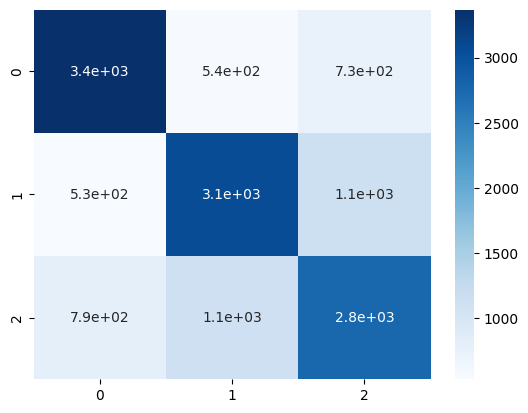

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
model5 = DecisionTreeClassifier(min_samples_leaf=best_params5['min_samples_leaf'],max_depth=best_params5['max_depth'],criterion=best_params5['criterion'],random_state=0)
model5.fit(X_train_embeddings, y_train)
y_pred10 = model5.predict(X_test_embeddings)
cm = confusion_matrix(y_test, y_pred10)
print(cm)
sns.heatmap(cm,annot= True, cmap = "Blues")
accuracy = accuracy_score(y_test, y_pred10)
print(accuracy)
print(classification_report(y_test, y_pred10))
print("precision score", precision_score(y_test, y_pred10, average='weighted')) # Change is here
print("Recall score", recall_score(y_test, y_pred10, average='weighted')) # Change is here
print("f1 score", f1_score(y_test, y_pred10, average='weighted')) # Change is here
print("accuracy score", accuracy_score(y_test,y_pred10))


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py", line 2956, in log_loss
    y_pred = check_array(
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3

Cross-validation metrics:
Cross Accuracy: 0.6478205128205128
Cross Precision: 0.6493214358636064
Cross Recall: 0.6478205128205128
Cross F1 Score: 0.6463498417091864
Cross MCC: 0.47331970644519394
Cross Kappa: 0.4717307692307692
Cross Log-Loss: nan


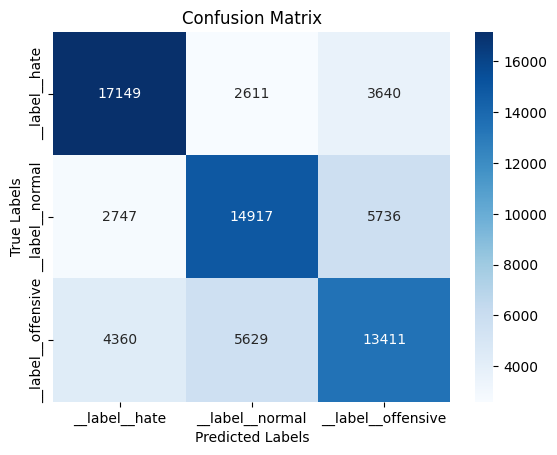

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, log_loss
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define scoring metrics for 3-class problem
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),  # Weighted for multi-class
    'recall': make_scorer(recall_score, average='weighted'),        # Weighted for multi-class
    'f1_score': make_scorer(f1_score, average='weighted'),          # Weighted for multi-class
    'matthews_corrcoef': make_scorer(matthews_corrcoef),            # MCC works for multi-class directly
    'cohen_kappa_score': make_scorer(cohen_kappa_score),            # Works for multi-class
    'log_loss': make_scorer(log_loss, greater_is_better=False)      # Lower is better
}

# Perform cross-validation
results = cross_validate(
    estimator=model5,
    X=X,  # Feature matrix
    y=Y,  # Target labels
    cv=10,  # 10-fold cross-validation
    scoring=scoring
)

# Print cross-validation results
print('Cross-validation metrics:')
print('Cross Accuracy:', np.mean(results['test_accuracy']))
print('Cross Precision:', np.mean(results['test_precision']))
print('Cross Recall:', np.mean(results['test_recall']))
print('Cross F1 Score:', np.mean(results['test_f1_score']))
print('Cross MCC:', np.mean(results['test_matthews_corrcoef']))
print('Cross Kappa:', np.mean(results['test_cohen_kappa_score']))
print('Cross Log-Loss:', np.mean(results['test_log_loss']))

# Predict labels using cross-validation
y_pred1 = cross_val_predict(model5, X, Y, cv=10)

# Compute confusion matrix
conf_mat = confusion_matrix(Y, y_pred1)

# Display the confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y), yticklabels=np.unique(Y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#Random Forest

In [ ]:
#Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
params6={
         'n_estimators':np.arange(100,600,100),
          'min_samples_leaf':[1,2,3,4],
        }
grid = RandomizedSearchCV(RandomForestClassifier(), params6, n_iter=40, verbose= True, n_jobs=-1, cv = 10, random_state=0)
grid.fit(X_train_embeddings,y_train)
print(grid.best_score_)
print(grid.best_params_)
best_params6 = grid.best_params_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 20 is smaller than n_iter=40. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 20 candidates, totalling 200 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# ------------------- Train Machine Learning Model -------------------
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_embeddings, y_train)

RandomForestClassifier(random_state=42)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py", line 2956, in log_loss
    y_pred = check_array(
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3

Cross-validation metrics:
Cross Accuracy: 0.7317521367521367
Cross Precision: 0.73390801993717
Cross Recall: 0.7317521367521367
Cross F1 Score: 0.7302571690211246
Cross MCC: 0.5997599012559587
Cross Kappa: 0.5976282051282051
Cross Log-Loss: nan


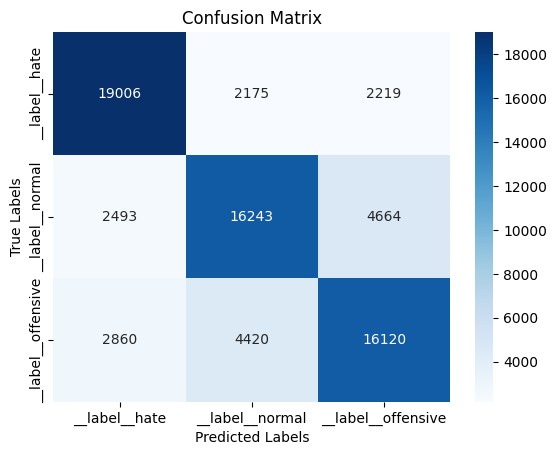

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, log_loss
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define scoring metrics for 3-class problem
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),  # Weighted for multi-class
    'recall': make_scorer(recall_score, average='weighted'),        # Weighted for multi-class
    'f1_score': make_scorer(f1_score, average='weighted'),          # Weighted for multi-class
    'matthews_corrcoef': make_scorer(matthews_corrcoef),            # MCC works for multi-class directly
    'cohen_kappa_score': make_scorer(cohen_kappa_score),            # Works for multi-class
    'log_loss': make_scorer(log_loss, greater_is_better=False)      # Lower is better
}

# Perform cross-validation
results = cross_validate(
    estimator=rf_model,
    X=X,  # Feature matrix
    y=Y,  # Target labels
    cv=10,  # 10-fold cross-validation
    scoring=scoring
)

# Print cross-validation results
print('Cross-validation metrics:')
print('Cross Accuracy:', np.mean(results['test_accuracy']))
print('Cross Precision:', np.mean(results['test_precision']))
print('Cross Recall:', np.mean(results['test_recall']))
print('Cross F1 Score:', np.mean(results['test_f1_score']))
print('Cross MCC:', np.mean(results['test_matthews_corrcoef']))
print('Cross Kappa:', np.mean(results['test_cohen_kappa_score']))
print('Cross Log-Loss:', np.mean(results['test_log_loss']))

# Predict labels using cross-validation
y_pred1 = cross_val_predict(rf_model, X, Y, cv=10)

# Compute confusion matrix
conf_mat = confusion_matrix(Y, y_pred1)

# Display the confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y), yticklabels=np.unique(Y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#Extra Tree Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
et_model = ExtraTreesClassifier(random_state=42, n_estimators=100)
et_model.fit(X_train_embeddings, y_train)

ExtraTreesClassifier(random_state=42)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py", line 2956, in log_loss
    y_pred = check_array(
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3

Cross-validation metrics:
Cross Accuracy: 0.7540313390313391
Cross Precision: 0.7571293196099178
Cross Recall: 0.7540313390313391
Cross F1 Score: 0.7522273474908222
Cross MCC: 0.6338715935803384
Cross Kappa: 0.6310470085470085
Cross Log-Loss: nan


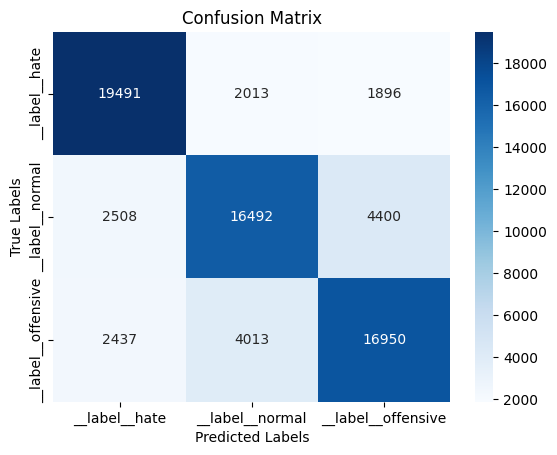

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, log_loss
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define scoring metrics for 3-class problem
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),  # Weighted for multi-class
    'recall': make_scorer(recall_score, average='weighted'),        # Weighted for multi-class
    'f1_score': make_scorer(f1_score, average='weighted'),          # Weighted for multi-class
    'matthews_corrcoef': make_scorer(matthews_corrcoef),            # MCC works for multi-class directly
    'cohen_kappa_score': make_scorer(cohen_kappa_score),            # Works for multi-class
    'log_loss': make_scorer(log_loss, greater_is_better=False)      # Lower is better
}

# Perform cross-validation
results = cross_validate(
    estimator=et_model,
    X=X,  # Feature matrix
    y=Y,  # Target labels
    cv=10,  # 10-fold cross-validation
    scoring=scoring
)

# Print cross-validation results
print('Cross-validation metrics:')
print('Cross Accuracy:', np.mean(results['test_accuracy']))
print('Cross Precision:', np.mean(results['test_precision']))
print('Cross Recall:', np.mean(results['test_recall']))
print('Cross F1 Score:', np.mean(results['test_f1_score']))
print('Cross MCC:', np.mean(results['test_matthews_corrcoef']))
print('Cross Kappa:', np.mean(results['test_cohen_kappa_score']))
print('Cross Log-Loss:', np.mean(results['test_log_loss']))

# Predict labels using cross-validation
y_pred1 = cross_val_predict(et_model, X, Y, cv=10)

# Compute confusion matrix
conf_mat = confusion_matrix(Y, y_pred1)

# Display the confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y), yticklabels=np.unique(Y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#Stack Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier
estimators = [('RF', rf_model),('ET',et_model )]
stackclassifier = StackingClassifier(estimators=estimators, final_estimator=model5)

In [ ]:
stackclassifier.fit(X_train_embeddings,y_train)

StackingClassifier(estimators=[('RF', RandomForestClassifier(random_state=42)),
                               ('ET', ExtraTreesClassifier(random_state=42))],
                   final_estimator=DecisionTreeClassifier(criterion='entropy',
                                                          max_depth=6,
                                                          min_samples_leaf=2,
                                                          random_state=0))

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py", line 2956, in log_loss
    y_pred = check_array(
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3

Cross-validation metrics:
Cross Accuracy: 0.752948717948718
Cross Precision: 0.7598137285562538
Cross Recall: 0.752948717948718
Cross F1 Score: 0.7512932854787812
Cross MCC: 0.6337384293709205
Cross Kappa: 0.629423076923077
Cross Log-Loss: nan


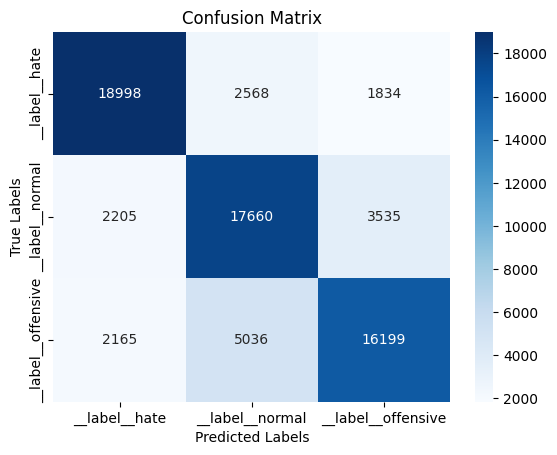

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, log_loss
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define scoring metrics for 3-class problem
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),  # Weighted for multi-class
    'recall': make_scorer(recall_score, average='weighted'),        # Weighted for multi-class
    'f1_score': make_scorer(f1_score, average='weighted'),          # Weighted for multi-class
    'matthews_corrcoef': make_scorer(matthews_corrcoef),            # MCC works for multi-class directly
    'cohen_kappa_score': make_scorer(cohen_kappa_score),            # Works for multi-class
    'log_loss': make_scorer(log_loss, greater_is_better=False)      # Lower is better
}

# Perform cross-validation
results = cross_validate(
    estimator=stackclassifier,
    X=X,  # Feature matrix
    y=Y,  # Target labels
    cv=10,  # 10-fold cross-validation
    scoring=scoring
)

# Print cross-validation results
print('Cross-validation metrics:')
print('Cross Accuracy:', np.mean(results['test_accuracy']))
print('Cross Precision:', np.mean(results['test_precision']))
print('Cross Recall:', np.mean(results['test_recall']))
print('Cross F1 Score:', np.mean(results['test_f1_score']))
print('Cross MCC:', np.mean(results['test_matthews_corrcoef']))
print('Cross Kappa:', np.mean(results['test_cohen_kappa_score']))
print('Cross Log-Loss:', np.mean(results['test_log_loss']))

# Predict labels using cross-validation
y_pred1 = cross_val_predict(stackclassifier, X, Y, cv=10)

# Compute confusion matrix
conf_mat = confusion_matrix(Y, y_pred1)

# Display the confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y), yticklabels=np.unique(Y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#LIME explainability

In [ ]:
a = df['Lemmatized_Text']
b= df['label']

In [ ]:
lime_explainer = LimeTextExplainer(class_names=["Hateful", "Normal", "Offensive"])
instance_idx = 4  # Choose a specific test instance

In [ ]:
lime_exp = lime_explainer.explain_instance(
    a.iloc[instance_idx],  # Original text
    lambda x: stackclassifier.predict_proba(np.array([generate_fasttext_embedding(t) for t in x])),  # Custom prediction function
    num_features=10             # Top 10 impactful words
)

In [ ]:
# Show LIME explanation
lime_exp.show_in_notebook(text=True)

In [ ]:
b.iloc[instance_idx]

'__label__normal'